Open this notebook in Google Colab <a target="_blank" href="https://colab.research.google.com/github/neo4j-contrib/neo4j-spark-connector/blob/5.0/examples/neo4j_data_engineering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Example of a Simple data engineering workflow with Neo4j and Spark

This notebook contains a set of examples that explains how the Neo4j Spark connector can fit in you Data Engineering workflow, how to write your Spark jobs, how to read/write data and mostly important it allows you to test your knowledge with a set of exercises after each section.

If you have any problem feel free to write a post in the [Neo4j community forum](https://community.neo4j.com/) or in [Discord](https://discord.com/invite/neo4j).

If you want more exercises feel free to open an issue in the [GitHub repository](https://github.com/neo4j-contrib/neo4j-spark-connector).

Enjoy!

# Create the sandbox instance

You can easily spin-up a Neo4j sandbox by click [here](https://sandbox.neo4j.com/?usecase=movies)

After that you'll be redirect in a webpage like this:

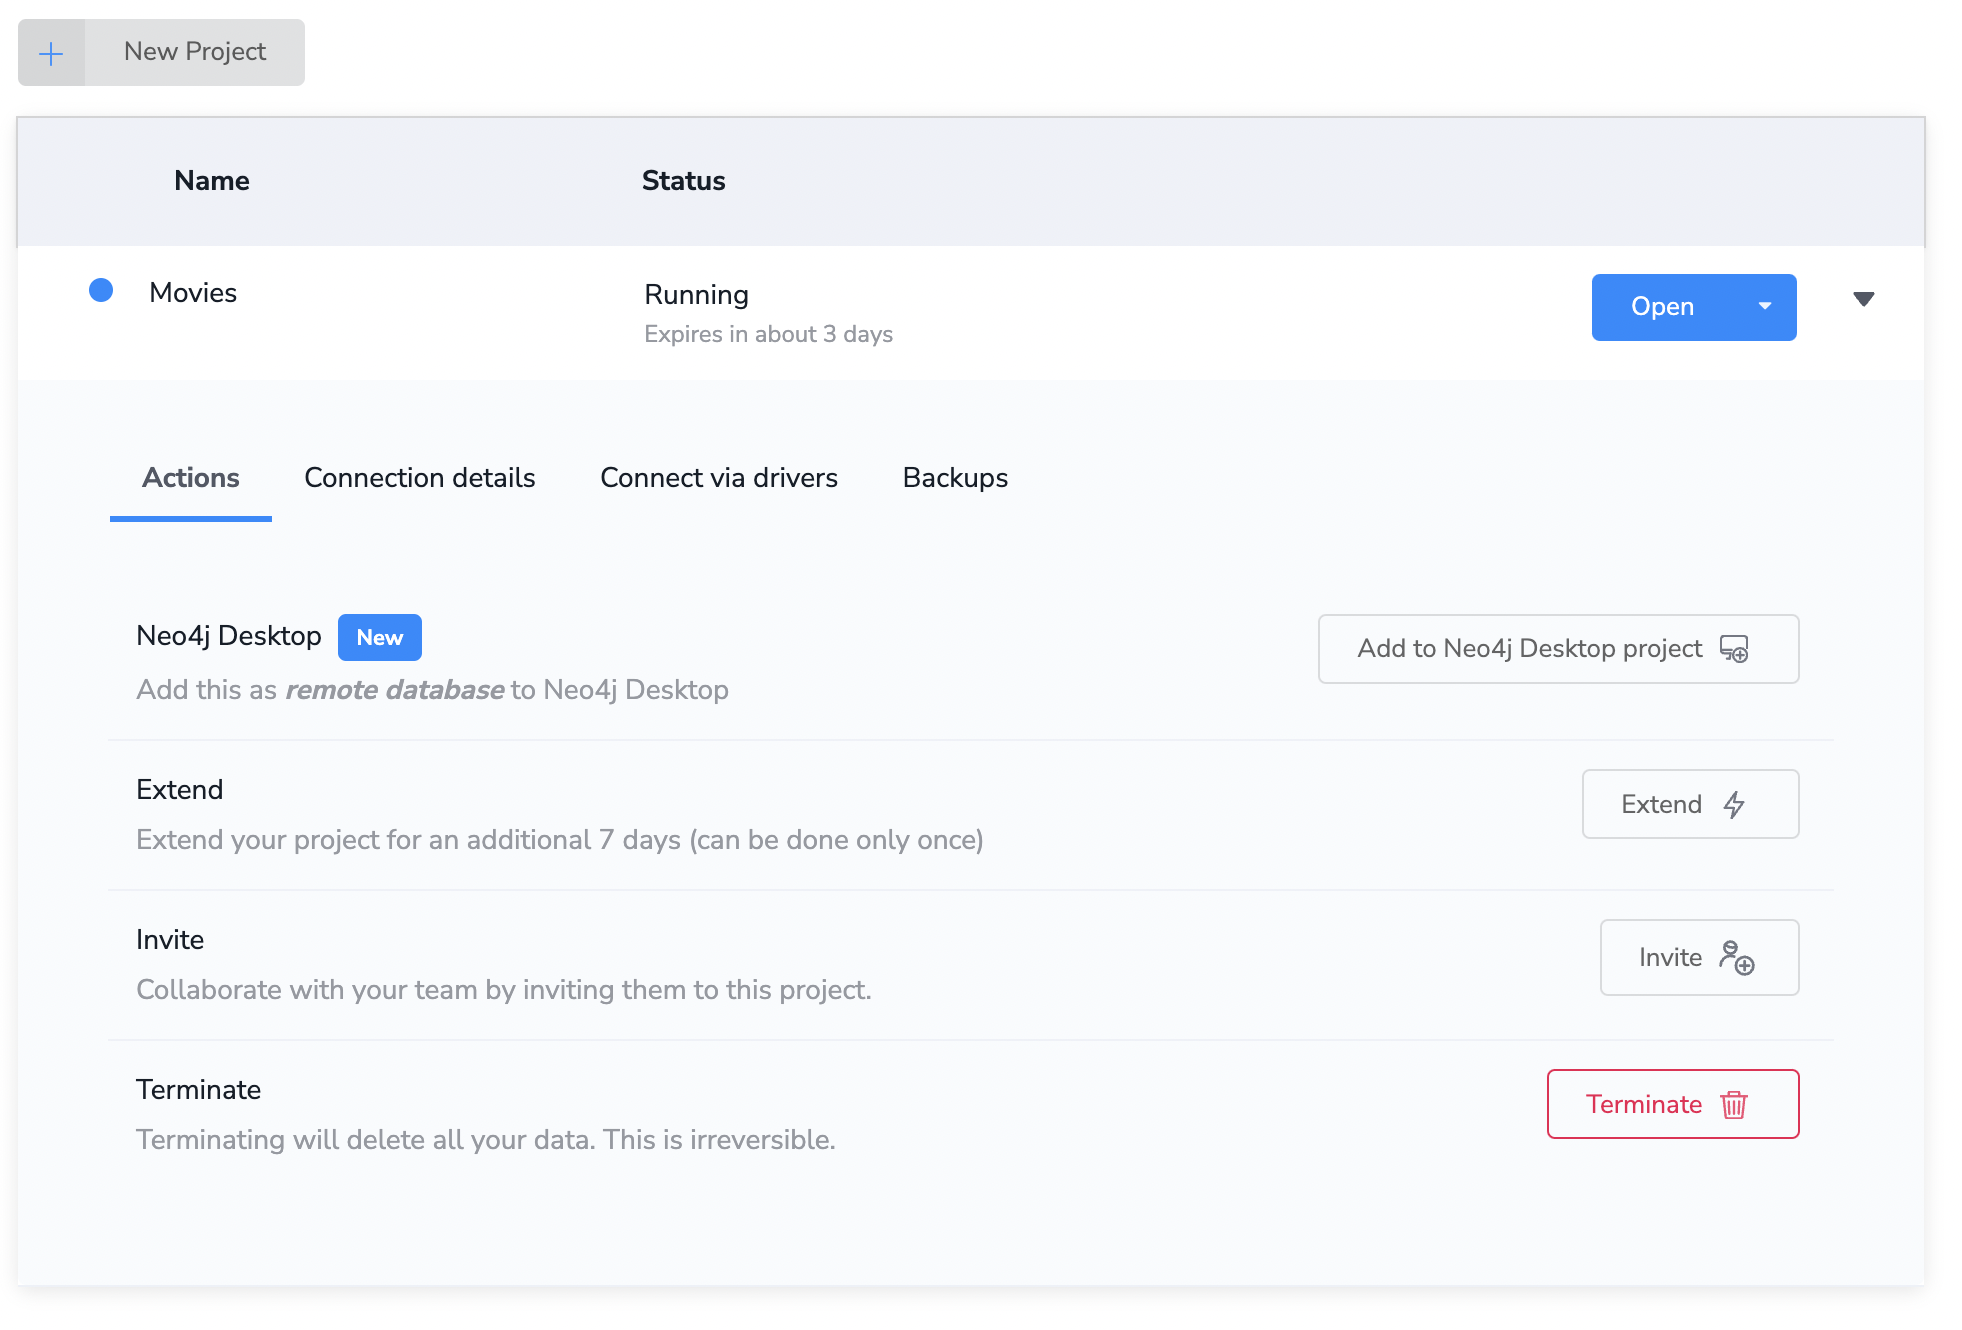

Please click in the **Connection details tab** and copy your connection parameters into the Python variables below

This will create the following graph model

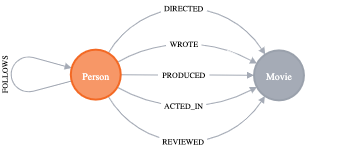

### Configure the Spark Environment

In [ ]:
!apt-get install openjdk-17-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
neo4j_url = "" # put your neo4j url here

In [ ]:
neo4j_user = "neo4j" # put your neo4j user here

In [ ]:
neo4j_password = "" # put your neo4j password here

In [ ]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
        .master('local[*]')
        .appName('Data engineering workflow with Neo4j and Spark')
        .config('spark.ui.port', '4050')
        # Just to show dataframes as tables
        .config('spark.sql.repl.eagerEval.enabled', True)
        .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.0.2_for_spark_3')
        # As we're using always the same database instance we'll
        # define them as global variables
        # so we don't need to repeat them each time
        .config("neo4j.url", neo4j_url)
        .config("neo4j.authentication.type", "basic")
        .config("neo4j.authentication.basic.username", neo4j_user)
        .config("neo4j.authentication.basic.password", neo4j_password)
        .getOrCreate())
spark


## Exercises prerequisite

In this notebook we'll let you do some exercises to test what you learned during this presentation. In some of them we user the Neo4j python driver in order to check if all the exercises are being solved properly

*Neo4j Python Driver is required only for verifying the exercises when you persist data from Spark to Neo4j*

**It's not required by the Spark connector!!!**

We'll use [Cy2Py](https://github.com/conker84/cy2py), a Jupyter extension that easily allows you to connect to Neo4j and visualize data from Jupyter notebooks.
For a detailed instruction about how to use it please dive into [this example](https://github.com/conker84/cy2py/blob/main/examples/Neo4j_Crime_Investigation_Dataset.ipynb)

In [ ]:
!pip install -q cy2py

let's load the extension

In [ ]:
%load_ext cy2py

You can query the database via **cy2py** in this simple way

In [ ]:
%%cypher -u $neo4j_url -us $neo4j_user -pw $neo4j_password
CALL apoc.meta.graph()

As you can see the model is exactely how we expect!

In [ ]:
# this step is MANDATORY for the exercises
from neo4j import GraphDatabase
neo4j_driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))

# Read data from Neo4j into Spark


The query above generates the following graph model:



## Read nodes via `labels` option

In [ ]:
movies_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('labels', ':Movie')
            .load())

### Schema description

In [ ]:
movies_df.printSchema()

The `movies_df` contains a set of fields, the first two (generally) are always:

* `<id>` which represents the internal Neo4j id
* `<labels>` which represents the list of labels attached to the node

All other properties are taken from the node via schema resolution by using APOC or Cypher queries

In [ ]:
movies_df

### Exercise

Read all the `Person` nodes store them into a Python variable called `person_df` and then verify the results

In [ ]:
person_df = # write your spark code here

<details>
<summary>
Show a possible solution
</summary>

```python
person_df = (spark.read
  .format('org.neo4j.spark.DataSource')
  .option('labels', ':Person')
  .load())
```

</details>



In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the person_df
"""

assert person_df.count() == 133
assert person_df.schema.fieldNames() == ['<id>', '<labels>', 'name', 'born']
assert person_df.collect()[0]["<labels>"] == ['Person']
print("All assertion are successfuly satisfied. Congrats you created your first DataFrame")

## Read relationships via `relationship` option

There are two way to transform relationships into DataFrame

* having all the node and relationship data flattened into the DataFrame
* having all the node properties in maps and the relationship data as columns

### DataFrame with flattened data

In [ ]:
actedin_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship', 'ACTED_IN')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())

### Schema description

In [ ]:
actedin_df.printSchema()

The `movies_df` contains a set of fields, the first two (generally) are always:

* `<rel.id>` which represents the internal Neo4j relationship id
* `<rel.type>` which represents the relationship type
* `<source/target.id>` which represents the internal Neo4j node id
* `<source/target.labels>` which represents the list of labels attached to the node
* `rel.*` which represents the properties attached to the relationship
* `source/target.*` which represents the properties attached to the node

All other properties are taken from the node via schema resolution by using APOC or Cypher queries

In [ ]:
actedin_df

### DataFrame with nodes as map

In [ ]:
actedin_map_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship.nodes.map', True)
            .option('relationship', 'ACTED_IN')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())

### Schema description

In [ ]:
actedin_map_df.printSchema()

The `movies_df` contains a set of fields, the first two (generally) are always:

* `<rel.id>` which represents the internal Neo4j relationship id
* `<rel.type>` which represents the relationship type
* `<source/target>` which represents a map with node values
* `rel.*` which represents the properties attached to the relationship

All other properties are taken from the node via schema resolution by using APOC or Cypher queries

In [ ]:
actedin_map_df

In [ ]:
actedin_map_df.collect()[0]["<source>"]

### Exercise

Read all the `DIRECTED` relationships

In [ ]:
directed_df = # write your spark code here

<details>
<summary>
Show a possible solution
</summary>

```python
directed_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('relationship', 'DIRECTED')
            .option('relationship.source.labels', ':Person')
            .option('relationship.target.labels', ':Movie')
            .load())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the directed_df
"""

assert directed_df.count() == 44
assert directed_df.schema.fieldNames() == ['<rel.id>',
 '<rel.type>',
 '<source.id>',
 '<source.labels>',
 'source.name',
 'source.born',
 '<target.id>',
 '<target.labels>',
 'target.title',
 'target.tagline',
 'target.released']
assert directed_df.collect()[0]["<rel.type>"] == 'DIRECTED'
print("All assertion are successfuly satisfied. Congrats you created your first relationship DataFrame")

## Read arbitrary data via Cypher query

In [ ]:
cypher_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('query', '''
              // Extend Tom Hanks co-actors, to find co-co-actors who haven't worked with Tom Hanks
              MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
                (coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors)
              WHERE NOT (tom)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors)
                AND tom <> cocoActors
              RETURN cocoActors.name AS Recommended, count(*) AS Strength
              ORDER BY Strength DESC
            ''')
            .load())

### Schema description

In [ ]:
cypher_df.printSchema()

In [ ]:
cypher_df

In [ ]:
%%cypher
// Just for debugging purposes let's check the same query directly from the database
MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(coActors),
  (coActors)-[:ACTED_IN]->(m2)<-[:ACTED_IN]-(cocoActors)
WHERE NOT (tom)-[:ACTED_IN]->()<-[:ACTED_IN]-(cocoActors)
  AND tom <> cocoActors
RETURN cocoActors.name AS Recommended, count(*) AS Strength
ORDER BY Strength DESC
LIMIT 20

### Exercise

Return all the actors that have also directed a movie.

The returned DataFrame must have 3 columns:

* `name` the actor name
* `acted_in` a list of unique films (title) where he acted in
* `directed` a list of unique films (title) where he was a director

In [ ]:
your_cypher_df = # write your spark code here

<details>
<summary>
Show a possible solution
</summary>

```python
your_cypher_df = (spark.read
            .format('org.neo4j.spark.DataSource')
            .option('query', '''
              MATCH (p:Person)
              MATCH (p)-[:ACTED_IN]->(m:Movie)
              MATCH (p)-[:DIRECTED]->(m1:Movie)
              RETURN p.name AS name, collect(m.title) AS acted_in, collect(m1.title) AS directed
            ''')
            .load())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 created the your_cypher_df
"""

assert your_cypher_df.count() == 5
assert your_cypher_df.schema.fieldNames() == ['name', 'acted_in', 'directed']
your_cypher_df_collect = your_cypher_df.collect()
assert frozenset(map(lambda row: row['name'], your_cypher_df_collect)) == frozenset(['Clint Eastwood',
 'Danny DeVito',
 'James Marshall',
 'Werner Herzog',
 'Tom Hanks'])
assert frozenset(map(lambda row: frozenset(row['acted_in']), your_cypher_df_collect)) == set([
      frozenset(["Apollo 13", "You've Got Mail", "A League of Their Own", "Joe Versus the Volcano", "That Thing You Do", "The Da Vinci Code", "Cloud Atlas", "Cast Away", "The Green Mile", "Sleepless in Seattle", "The Polar Express", "Charlie Wilson's War"]),
      frozenset(["What Dreams May Come"]),
      frozenset(["Unforgiven"]),
      frozenset(["A Few Good Men"]),
      frozenset(["Hoffa", "One Flew Over the Cuckoo's Nest"])
    ])
assert frozenset(map(lambda row: frozenset(row['directed']), your_cypher_df_collect)) == set([
      frozenset(["That Thing You Do"]),
      frozenset(["RescueDawn"]),
      frozenset(["Unforgiven"]),
      frozenset(["V for Vendetta", "Ninja Assassin"]),
      frozenset(["Hoffa"])
    ])
print("All assertion are successfuly satisfied. Congrats you created your first cypher dataframe")

# Write data from Spark to Neo4j

## The graph model

Our gol is to create this simple graph model

<img src="https://dist.neo4j.com/wp-content/uploads/developer-desktop-csv-import-data_model.svg" >

### Download The Dataset

In [ ]:
!wget -q https://s3.amazonaws.com/dev.assets.neo4j.com/wp-content/uploads/desktop-csv-import.zip

The zip is composed of three files:
* products.csv: describes the products and has three columns (and no header)
* orders.csv: has three columns (with the header) and describe the order
* order-details.csv: is the "join" table between orders and products; it has three columns with header

In [ ]:
!unzip desktop-csv-import.zip

### Explore the Dataset

In [ ]:
products_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('path', '/content/desktop-csv-import/products.csv')
      .load())

In [ ]:
products_df.printSchema()

In [ ]:
products_df

As you can see in the schema, colums have no name, just a generic `_c` prefix concatenated with an index.
The three columns describe:
* `_c0` is the `id` of the product
* `_c1` is the `name`
* `_c2` is the `price`

Let's rename these columns!

In [ ]:
products_df = (products_df.withColumnRenamed('_c0', 'id')
      .withColumnRenamed('_c1', 'name')
      .withColumnRenamed('_c2', 'price'))

In [ ]:
products_df.printSchema()

In [ ]:
products_df

## Write nodes via `label` option

In [ ]:
(products_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('append')
 .option('labels', ':Product')
 .save())

Let's check if the nodes are in the database!

In [ ]:
%%cypher
MATCH (n:Product)
RETURN n
LIMIT 10

Now just to be sure that we loaded all the nodes into Neo4j we'll count the dataframe and the nodes inside the database

In [ ]:
products_df.count()

In [ ]:
%%cypher
MATCH (n:Product)
RETURN count(n)

If the two counts are equal, all the data has been properly imported.

### Create Constraints

Oh but wait, we forgot to create constraints!!! if we go into the Neo4j browser and excute the following query:

```cypher
show constraints
```

We should get the constraints of the movie database, but not one for `Product`.

So please create the constaints for the node `Product`:

```cypher
CREATE CONSTRAINT product_id FOR (p:Product) REQUIRE p.id IS UNIQUE;
```

But if you want, you can also delegate the Spark connector to perform optimizations pre-processing by usign the option `schema.optimization.type` which can assume three values:

* `INDEX`: it creates only indexes on provided nodes.
* `NODE_CONSTRAINTS`: it creates only indexes on provided nodes.

So let's create the `Order` node with by let the connector creating the constraints for you

In [ ]:
%%cypher
// Check the constraints
SHOW CONSTRAINTS

In [ ]:
%%cypher
// Create the constraint for Product node
CREATE CONSTRAINT product_id IF NOT EXISTS FOR (p:Product) REQUIRE p.id IS UNIQUE;

In [ ]:
%%cypher
// Check (again) the constraints
SHOW CONSTRAINTS

As you can see now we have the `product_id` constraint in the result list

In [ ]:
orders_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('header', True)
      .option('path', '/content/desktop-csv-import/orders.csv')
      .load())

In [ ]:
orders_df.printSchema()

In [ ]:
orders_df

In [ ]:
# we cast orderDate to timestamp in order to have it converted properly into Neo4j
orders_df = orders_df.selectExpr('orderID AS id', 'CAST(orderDate AS TIMESTAMP) AS date', 'shipCountry')

In [ ]:
orders_df.printSchema()

In [ ]:
orders_df

In [ ]:
(orders_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':Order')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 # this is necessary in order to specify what is the constraint field
 .option('node.keys', 'id')
 .save())

Now let's check if the connector has created the constraint for us

In [ ]:
%%cypher
SHOW CONSTRAINTS

As you can see the we have the constraint `spark_NODE_CONSTRAINTS_Order_id` that has been create by the Spark connector itself.

Now just because we're courious let's check if the data has been propertly loaded.

The first thing to check is if the count of the Dataframe and the nodes in Neo4j matches.

In [ ]:
orders_df.count()

In [ ]:
%%cypher
MATCH (o:Order)
RETURN count(o)

Now we want to check if the data has been loaded with the proper data type, in particular we created a new column `date` by casting `orderDate` to `TIMESTAMP`.

In [ ]:
%%cypher
MATCH (o:Order)
RETURN apoc.meta.cypher.type(o.date), count(o)

So all the `date` values have the same type.

### Exercise

Given the `football_teams_df` and `football_player_df` below please:
* for `football_teams_df` insert it as nodes with label `:FootballTeam` in Neo4j.
* for `football_player_df` insert it as nodes with label `:FootballPlayer` in Neo4j.

Create for both of them constraints via the schema optimization feature:
* for `football_teams_df` the key must be the property `id`
* for `football_player_df` the key must be the property `name`

In [ ]:
football_teams_df = spark.createDataFrame([{'id': 1, 'name': 'AC Milan'}, {'id': 2, 'name': 'FC Internazionale'}])
football_player_df = spark.createDataFrame([
  {'name': 'Zlatan Ibrahimovic'},
  {'name': 'Sandro Tonali'},
  {'name': 'Nicolò Barella'},
  {'name': 'Marcelo Brozovic'}])

In [ ]:
# write your spark code that persist football_teams_df and football_player_df here

<details>
<summary>
Show a possible solution
</summary>

```python
# write the teams
(football_teams_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':FootballTeam')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 .option('node.keys', 'id')
 .save())
# write the players
(football_player_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('labels', ':FootballPlayer')
 .option('schema.optimization.type', 'NODE_CONSTRAINTS')
 .option('node.keys', 'name')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted football_teams_df and
 football_player_df in Neo4j as nodes
"""

with neo4j_driver.session() as session:
  # count football players
  football_players = session.read_transaction(lambda tx: (tx.run('''
      MATCH (p:FootballPlayer)
      WHERE p.name IN ['Zlatan Ibrahimovic', 'Sandro Tonali',
        'Nicolò Barella', 'Marcelo Brozovic']
      RETURN count(p) AS count
    ''').single()['count']))
  assert football_players == 4

  # count football teams
  football_teams = session.read_transaction(lambda tx: (tx.run('''
      MATCH (p:FootballTeam)
      WHERE p.name IN ['AC Milan', 'FC Internazionale']
      RETURN count(p) AS count
    ''').single()['count']))
  assert football_teams == 2

  # count constraints
  football_constraints = session.read_transaction(lambda tx: (tx.run('''
      SHOW CONSTRAINTS YIELD name
      WHERE name IN ['spark_NODE_CONSTRAINTS_FootballPlayer_name', 'spark_NODE_CONSTRAINTS_FootballTeam_id']
      RETURN count(*) AS count
    ''').single()['count']))
  assert football_constraints == 2

print("All assertion are successfuly satisfied. Congrats you saved your first Node DataFrame into Neo4j!")

## Write relationships via `relationship` option

In [ ]:
order_details_df = (spark.read
      .format('csv')
      .option('inferSchema', True)
      .option('header', True)
      .option('path', '/content/desktop-csv-import/order-details.csv')
      .load())

In [ ]:
order_details_df.printSchema()

In [ ]:
order_details_df

Please remember that this is the pattern that we want to ingest:


<img src="https://dist.neo4j.com/wp-content/uploads/developer-desktop-csv-import-data_model.svg" >

In [ ]:
(order_details_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('relationship', 'CONTAINS')
 .option('relationship.save.strategy', 'keys')
 .option('relationship.source.labels', ':Product')
 .option('relationship.source.save.mode', 'Match')
 .option('relationship.source.node.keys', 'productID:id')
 .option('relationship.target.labels', ':Order')
 .option('relationship.target.save.mode', 'Match')
 .option('relationship.target.node.keys', 'orderID:id')
 .option('relationship.properties', 'quantity:quantityOrdered')
 .save())

Now let's check the count for both Dataframe and relationships in Neo4j

In [ ]:
order_details_df.count()

In [ ]:
%%cypher
MATCH (p:Product)-[r:CONTAINS]->(o:Order)
RETURN count(r)

### Exercise

Given the `team_player_df` create a relationship between `:FootballPlayer` and `:FootballTeam` of type `PLAYS_FOR`:

```cypher
(:FootballPlayer)-[:PLAYS_FOR]->(:FootballTeam)
```

In [ ]:
team_player_df = spark.createDataFrame([
  {'id': 1, 'football_player': 'Zlatan Ibrahimovic'},
  {'id': 1, 'football_player': 'Sandro Tonali'},
  {'id': 2, 'football_player': 'Nicolò Barella'},
  {'id': 2, 'football_player': 'Marcelo Brozovic'}])

In [ ]:
# write your spark code that persist team_player_df here

<details>
<summary>
Show a possible solution
</summary>

```python
(team_player_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('relationship', 'PLAYS_FOR')
 .option('relationship.save.strategy', 'keys')
 .option('relationship.source.labels', ':FootballPlayer')
 .option('relationship.source.save.mode', 'Match')
 .option('relationship.source.node.keys', 'football_player:name')
 .option('relationship.target.labels', ':FootballTeam')
 .option('relationship.target.save.mode', 'Match')
 .option('relationship.target.node.keys', 'id')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted team_player_df as relationships
"""

with neo4j_driver.session() as session:
  # count relationships
  def count_relationships(tx):
    result = tx.run('''
      MATCH (p:FootballPlayer)-[:PLAYS_FOR]->(t:FootballTeam)
      RETURN t.name AS team, collect(p.name) AS players
      ORDER by team
    ''')
    return [{'team': record['team'], 'players': set(record['players'])} for record in result]

  actual = session.read_transaction(count_relationships)
  expected = [
    {'team': 'AC Milan', 'players': frozenset(['Zlatan Ibrahimovic', 'Sandro Tonali'])},
    {'team': 'FC Internazionale', 'players': frozenset(['Nicolò Barella', 'Marcelo Brozovic'])}
  ]
  assert actual == expected

print("All assertion are successfuly satisfied. Congrats you saved your first Relationship DataFrame into Neo4j!")

## Write custom graphs via Cypher Query

Now let's consider that two actors created an order and bought several products, and we want to add information in our database.

In [ ]:
actor_orders = [
  {'actor_name': 'Cuba Gooding Jr.', 'order_id': 1, 'products': [11, 42, 72], 'quantities': [1, 2, 3], 'order_date': '2022-06-07 00:00:00'},
  {'actor_name': 'Tom Hanks', 'order_id': 2, 'products': [24, 55, 75], 'quantities': [3, 2, 1], 'order_date': '2022-06-06 00:00:00'}
]

actor_orders_df = spark.createDataFrame(actor_orders)

In [ ]:
actor_orders_df.printSchema()

In [ ]:
actor_orders_df

In this case please go into Neo4j and create the following constraint:

```cypher
CREATE CONSTRAINT person_name FOR (p:Person) REQUIRE p.name is UNIQUE;
```

In [ ]:
%%cypher
// if you didn't before create the constraint on Person.name
CREATE CONSTRAINT person_name IF NOT EXISTS FOR (p:Person) REQUIRE p.name is UNIQUE;

In [ ]:
(actor_orders_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('query', '''
  MATCH (person:Person {name: event.actor_name})
  MERGE (order:Order {id: event.order_id, date: datetime(replace(event.order_date, ' ', 'T'))})
  MERGE (person)-[:CREATED]->(order)
  WITH event, order
  UNWIND range(0, size(event.products) - 1) AS index
  MATCH (product:Product {id: event.products[index]})
  MERGE (product)-[:CONTAINS{quantityOrdered: event.quantities[index]}]->(order)
 ''')
 .save())

What we expect now is that for the two actors there are two orders one per each, then each order contains three products.

In [ ]:
%%cypher
MATCH (a:Person)-[:CREATED]->(o:Order)<-[c:CONTAINS]-(p:Product)
WHERE a.name IN ['Cuba Gooding Jr.', 'Tom Hanks']
RETURN a.name, o.id, o.date, p.name, c.quantityOrdered

### Exercise

Given `neo4j_resources_df` build a small Knowledge Graph in Neo4j with the following structure:

```cypher
(:Author{name})-[:CREATED]->(:Resource{name})-[:HAS_TAG]->(:Tag{name})
```

In [ ]:
neo4j_resources_df = spark.createDataFrame([
    {'author': 'LARUS Business Automation', 'resource': 'Galileo.XAI', 'tags': ['Graph Machine Learning', 'Neo4j', 'Explainable AI', 'Artificial Intelligence']},
    {'author': 'Neo4j', 'resource': 'Graph Data Science Library', 'tags': ['Graph Machine Learning', 'Algorithms']},
    {'author': 'Michael Hunger', 'resource': 'APOC', 'tags': ['Graph Data Integration', 'Graph Algorithms']}
])

In [ ]:
neo4j_resources_df

In [ ]:
# write your spark code that persist neo4j_resources_df here

<details>
<summary>
Show a possible solution
</summary>

```python
(neo4j_resources_df.write
 .format('org.neo4j.spark.DataSource')
 .mode('overwrite')
 .option('query', '''
    MERGE (a:Author {name: event.author})
    MERGE (r:Resource {name: event.resource})
    MERGE (a)-[:CREATED]->(r)
    WITH a, r, event
    UNWIND event.tags AS tag
    MERGE (t:Tag{name: tag})
    MERGE (r)-[:HAS_TAG]->(t)
 ''')
 .save())
```

</details>

In [ ]:
"""
 This paragraph is for validating the code the you
 wrote above, please execute it after you
 persisted neo4j_resources_df as Cypher query
"""

with neo4j_driver.session() as session:
  # count relationships
  def check_graph_consistency(tx):
    result = tx.run('''
      MATCH (a:Author)-[:CREATED]->(r:Resource)-[:HAS_TAG]->(t:Tag)
      RETURN a.name AS author, r.name AS resource, collect(t.name) AS tags
      ORDER By author
    ''')
    return [{'author': record['author'], 'resource': record['resource'], 'tags': set(record['tags'])} for record in result]

  actual = session.read_transaction(check_graph_consistency)
  expected = [
    {'author': 'LARUS Business Automation', 'resource': 'Galileo.XAI', 'tags': frozenset(['Graph Machine Learning', 'Neo4j', 'Explainable AI', 'Artificial Intelligence'])},
    {'author': 'Michael Hunger', 'resource': 'APOC', 'tags': frozenset(['Graph Data Integration', 'Graph Algorithms'])},
    {'author': 'Neo4j', 'resource': 'Graph Data Science Library', 'tags': frozenset(['Graph Machine Learning', 'Algorithms'])}
  ]
  assert actual == expected

print("All assertion are successfuly satisfied. Congrats you saved your first Knowledge Graph DataFrame into Neo4j!")